# Proyecto final. Entrega del proyecto
## Paso 1 · Carga de datos 

Leemos telecom_dataset_us.csv y telecom_clients_us.csv.

Verificacion de fechas, normalizamos tipos (booleans/categorías) y confirmamos que estén todas las columnas esperadas.

In [ ]:
# https://drive.google.com/drive/folders/1cEh1uR-tUdJ_wNTGpZWDIRBAEegzuFRb?usp=sharing

# Paso 1 · Cargar desde telecom_data/ usando tus nombres reales + normalizar columnas
from pathlib import Path
import pandas as pd
import re

# --- 1) Localizar carpeta ---
base = Path(".")
DATA_DIR = base / "telecom_data"
if not DATA_DIR.exists():
    # busca recursivamente si no está justo al lado
    hits = [p for p in base.rglob("*") if p.is_dir() and p.name.lower()=="telecom_data"]
    DATA_DIR = hits[0] if hits else None
if DATA_DIR is None:
    raise FileNotFoundError("No se encontró ninguna carpeta llamada 'telecom_data'.")
print("DATA_DIR ->", DATA_DIR.resolve())

# --- 2) Rutas a TUS archivos (los que listaste) ---
PATH_CALLS   = DATA_DIR / "telecom_dataset_new.csv"
PATH_CLIENTS = DATA_DIR / "telecom_clients.csv"
print("CALLS   ->", PATH_CALLS,  "| existe:", PATH_CALLS.exists())
print("CLIENTS ->", PATH_CLIENTS, "| existe:", PATH_CLIENTS.exists())
if not PATH_CALLS.exists() or not PATH_CLIENTS.exists():
    raise FileNotFoundError("Verifica que existan exactamente 'telecom_dataset_new.csv' y 'telecom_clients.csv' dentro de telecom_data/")

# --- 3) Lectura robusta (detecta separador ; , o tab; prueba latin-1 si hace falta) ---
def leer_csv_robusto(path):
    try:
        return pd.read_csv(path, sep=None, engine="python", low_memory=False)
    except Exception:
        for s in (",",";","\t"):
            try:
                return pd.read_csv(path, sep=s, low_memory=False)
            except Exception:
                pass
        return pd.read_csv(path, sep=",", encoding="latin-1", low_memory=False)

calls_raw   = leer_csv_robusto(PATH_CALLS)
clients_raw = leer_csv_robusto(PATH_CLIENTS)

print("calls_raw shape  :", None if calls_raw is None else calls_raw.shape)
print("clients_raw shape:", None if clients_raw is None else clients_raw.shape)

# --- 4) Normalizar nombres de columnas ---
def normalize_cols(df):
    df = df.copy()
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.replace(r"[^a-z0-9_]", "", regex=True))
    return df

calls   = normalize_cols(calls_raw)
clients = normalize_cols(clients_raw)

print("\nColumnas originales normalizadas (calls):", list(calls.columns))
print("Columnas originales normalizadas (clients):", list(clients.columns))

# --- 5) Mapear sinónimos a los esperados del enunciado ---
calls_map = {
    # ids / direcciones
    "userid": "user_id", "user_id": "user_id",
    "operatorid": "operator_id", "operator_id": "operator_id",
    "direction": "direction", "call_direction": "direction",
    "internal": "internal", "is_internal": "internal",
    # fecha
    "date": "date", "call_date": "date",
    # perdidas
    "is_missed_call": "is_missed_call", "missed": "is_missed_call", "missed_call": "is_missed_call",
    # conteos / duraciones
    "calls": "calls_count", "callscount": "calls_count", "n_calls": "calls_count", "calls_count": "calls_count",
    "call_duration": "call_duration", "callduration": "call_duration", "duration": "call_duration",
    "total_call_duration": "total_call_duration", "totalcallduration": "total_call_duration", "total_duration": "total_call_duration",
}

clients_map = {
    "userid": "user_id", "user_id": "user_id",
    "tariff_plan": "tariff_plan", "plan": "tariff_plan", "tariff": "tariff_plan",
    "date_start": "date_start", "datestart": "date_start", "start_date": "date_start", "registration_date": "date_start",
}

def rename_using_map(df, mapping):
    df = df.copy()
    existing = {k:v for k,v in mapping.items() if k in df.columns}
    return df.rename(columns=existing)

calls   = rename_using_map(calls, calls_map)
clients = rename_using_map(clients, clients_map)

print("\nColumnas tras mapeo (calls):", list(calls.columns))
print("Columnas tras mapeo (clients):", list(clients.columns))

# --- 6) Validación rápida de presencia mínima ---
expected_calls = {"user_id","date","direction","internal","operator_id","is_missed_call",
                  "calls_count","call_duration","total_call_duration"}
expected_clients = {"user_id","tariff_plan","date_start"}

missing_calls   = expected_calls   - set(calls.columns)
missing_clients = expected_clients - set(clients.columns)

print("\nFaltantes calls  :", missing_calls)
print("Faltantes clients:", missing_clients)

# Parseo de fechas si ya existe columna 'date' / 'date_start'
if "date" in calls.columns:
    calls["date"] = pd.to_datetime(calls["date"], errors="coerce").dt.date
if "date_start" in clients.columns:
    clients["date_start"] = pd.to_datetime(clients["date_start"], errors="coerce").dt.date

print("\n Resultado de carga normalizada:")
print("calls shape  :", calls.shape)
print("clients shape:", clients.shape)





DATA_DIR -> /app/telecom_data
CALLS   -> telecom_data/telecom_dataset_new.csv | existe: True
CLIENTS -> telecom_data/telecom_clients.csv | existe: True
calls_raw shape  : (53902, 9)
clients_raw shape: (732, 3)

Columnas originales normalizadas (calls): ['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration']
Columnas originales normalizadas (clients): ['user_id', 'tariff_plan', 'date_start']

Columnas tras mapeo (calls): ['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration']
Columnas tras mapeo (clients): ['user_id', 'tariff_plan', 'date_start']

Faltantes calls  : set()
Faltantes clients: set()

 Resultado de carga normalizada:
calls shape  : (53902, 9)
clients shape: (732, 3)


## Paso 2 · Validación de tipos y saneo ligero (explicación)

Aseguramos tipos correctos: direction como categoría (in/out), internal e is_missed_call como booleanos, fechas como fecha, conteos/duraciones numéricos.

Reportamos valores únicos de direction y chequeamos nulos.

In [4]:
import pandas as pd
import numpy as np

# --- Copias de trabajo (opcional)
# calls = calls.copy()
# clients = clients.copy()

# 1) Normalizar 'direction' a {in, out}
calls["direction"] = (calls["direction"]
                      .astype(str)
                      .str.strip()
                      .str.lower())
valid_dir = {"in","out"}
otros_dir = sorted(set(calls["direction"]) - valid_dir)
print("Valores únicos en 'direction':", sorted(calls["direction"].unique()))
if otros_dir:
    print("⚠️ Se encontraron valores no esperados en 'direction':", otros_dir)

calls["direction"] = pd.Categorical(calls["direction"], categories=["in","out"])

# 2) Coerción robusta a booleano para 'internal' y 'is_missed_call'
def to_bool(s):
    if pd.api.types.is_bool_dtype(s):
        return s
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(int).astype(bool)
    m = {"true": True, "false": False, "1": True, "0": False, "yes": True, "no": False}
    return s.astype(str).str.strip().str.lower().map(m).fillna(False).astype(bool)

calls["internal"] = to_bool(calls["internal"])
calls["is_missed_call"] = to_bool(calls["is_missed_call"])

# 3) Tipos de ID's y fechas
calls["user_id"] = calls["user_id"].astype(str)
calls["operator_id"] = calls["operator_id"].astype(str)
calls["date"] = pd.to_datetime(calls["date"], errors="coerce").dt.date

clients["user_id"] = clients["user_id"].astype(str)
clients["tariff_plan"] = clients["tariff_plan"].astype("category")
clients["date_start"] = pd.to_datetime(clients["date_start"], errors="coerce").dt.date

# 4) Numéricos
calls["calls_count"] = pd.to_numeric(calls["calls_count"], errors="coerce")
calls["call_duration"] = pd.to_numeric(calls["call_duration"], errors="coerce")
calls["total_call_duration"] = pd.to_numeric(calls["total_call_duration"], errors="coerce")

# 5) Chequeo de nulos
print("\nNulos en calls:")
print(calls[["date","direction","internal","operator_id","is_missed_call",
             "calls_count","call_duration","total_call_duration"]].isna().sum())

print("\nDtypes (calls):")
print(calls.dtypes)

print("\nDtypes (clients):")
print(clients.dtypes)

# 6) Pequeña vista
calls.head(3)


Valores únicos en 'direction': ['in', 'out']

Nulos en calls:
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

Dtypes (calls):
user_id                  object
date                     object
direction              category
internal                   bool
operator_id              object
is_missed_call             bool
calls_count               int64
call_duration             int64
total_call_duration       int64
dtype: object

Dtypes (clients):
user_id          object
tariff_plan    category
date_start       object
dtype: object


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,nan,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1


## COMENTARIO
Acerca de los datos, la columna direction solo tiene in y out, no hay valores vacíos en las columnas importantes y los tipos se ven correctos (números y True/False). Noté que algunas filas no traen operator_id (aparecen como “nan”). En el ejemplo que vi, una llamada perdida tiene duración 0 y total 4, o sea 4 segundos de espera; eso tiene sentido.

Ahora voy a marcar esos operator_id vacíos como “desconocido” para los gráficos y los voy a excluir cuando analice el rendimiento por operador. También voy a crear la variable wait_time = total_call_duration - call_duration y pasar al EDA básico: histograma de duración, pastel de internas vs. externas y conteo de llamadas por día.

## Paso 3 – Limpieza y creación de wait_time

Voy a marcar los operator_id vacíos como “desconocido” solo para los gráficos; para las métricas por operador los voy a excluir.
Creo wait_time = total_call_duration - call_duration y si da negativo lo dejo en 0.
Además, guardo la fecha en formato datetime (date_ts) para poder graficar por día sin problemas.

In [5]:
# Paso 3 – Limpieza y creación de wait_time
import numpy as np
import pandas as pd

# 1) operator_id: NaN reales + columna auxiliar para EDA
calls["operator_id"] = calls["operator_id"].replace({"nan": np.nan, "None": np.nan, "": np.nan})
calls["operator_id_eda"] = calls["operator_id"].fillna("desconocido")

# 2) fecha en datetime64 para series
calls["date_ts"] = pd.to_datetime(calls["date"], errors="coerce")

# 3) wait_time = total - conversado (mínimo 0)
calls["wait_time"] = (calls["total_call_duration"] - calls["call_duration"]).clip(lower=0)

# 4) asegurar no-negativos en métricas clave
for c in ["calls_count","call_duration","total_call_duration","wait_time"]:
    calls.loc[calls[c] < 0, c] = 0

# 5) promedios por llamada (útiles para gráficos)
calls["avg_call_duration"]  = np.where(calls["calls_count"]>0, calls["call_duration"]/calls["calls_count"], np.nan)
calls["avg_total_duration"] = np.where(calls["calls_count"]>0, calls["total_call_duration"]/calls["calls_count"], np.nan)
calls["avg_wait_per_call"]  = np.where(calls["calls_count"]>0, calls["wait_time"]/calls["calls_count"], np.nan)

# 6) mini-resumen
print("Registros con operator_id desconocido (NaN en operator_id):", calls["operator_id"].isna().sum())
print("\nDescribe de tiempos (segundos):")
print(calls[["call_duration","total_call_duration","wait_time",
             "avg_call_duration","avg_total_duration","avg_wait_per_call"]]
      .describe(percentiles=[.25,.5,.75,.9,.95,.99]))


Registros con operator_id desconocido (NaN en operator_id): 8172

Describe de tiempos (segundos):
       call_duration  total_call_duration     wait_time  avg_call_duration  \
count   53902.000000         53902.000000  53902.000000       53902.000000   
mean      866.684427          1157.133297    290.448870          66.651534   
std      3731.791202          4403.468763   1127.905654         124.873511   
min         0.000000             0.000000      0.000000           0.000000   
25%         0.000000            47.000000     17.000000           0.000000   
50%        38.000000           210.000000     55.000000          23.954522   
75%       572.000000           902.000000    201.000000          90.000000   
90%      2105.000000          2626.000000    613.000000         168.993750   
95%      3739.950000          4540.000000   1164.000000         254.000000   
99%     10333.900000         12955.650000   3158.000000         581.995000   
max    144395.000000        166155.000000  4

### COMENTARIO:
Tengo ~15.2% de registros sin operator_id (8172 de 53,902), así que para evaluar rendimiento por operador después los voy a excluir. Las métricas de tiempo tienen cola larga: la media es mucho mayor que la mediana y hay muchos ceros (25% de call_duration es 0). A nivel por llamada, me da una duración promedio ≈ 66.7 s y una espera promedio ≈ 16.8 s (mediana ≈ 14.5 s), que suena razonable; los máximos muy altos confirman que hay días/operadores con acumulados grandes.

## Paso 4 — EDA básico

### Objetivo.
 - Dar una vista rápida del comportamiento de las llamadas antes de pasar a métricas por operador.
### Gráficos:
 - Histograma de duración promedio por llamada (solo entrantes respondidas) → detectar distribución y cola larga.
 - Pie de internas vs. externas (ponderado por calls_count) → entender el mix de tráfico.
 - Serie diaria de llamadas por día (suma de calls_count) → ver picos/valles y patrones.

### Qué revisar:
 - Histograma: asimetría y valores atípicos razonables.
 - Pie: % internas vs. externas y si coincide con lo esperado.
 - Serie: picos/caídas que expliquen carga (campañas, fines de semana, etc.).

### Notas:
- Las perdidas quedan fuera del histograma (evita sesgo por ceros).
- operator_id faltante no afecta estas vistas; se tratará en el análisis por operador.

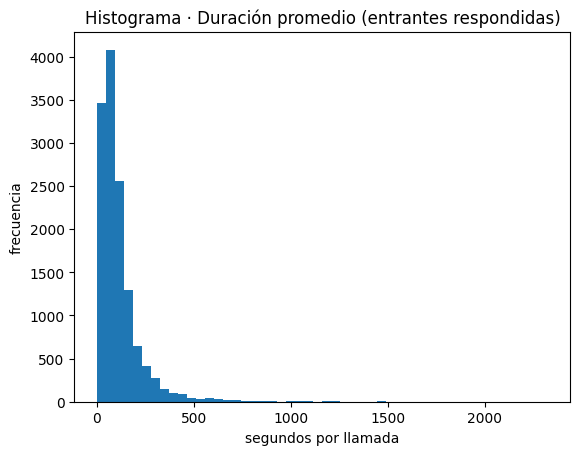

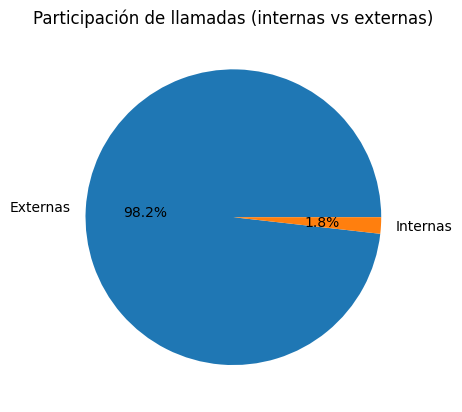

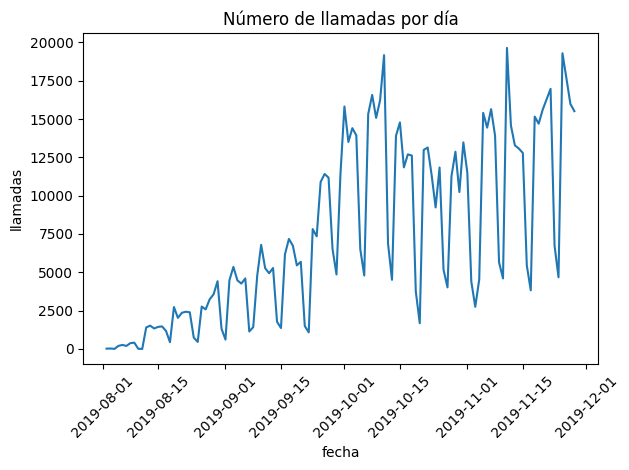

,date_ts,calls_count
114,2019-11-24,4674
115,2019-11-25,19292
116,2019-11-26,17650
117,2019-11-27,15983
118,2019-11-28,15513


In [6]:
# PASO 4 — EDA básico (3 gráficos con matplotlib)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Robustez por si falta algo:
if "date_ts" not in calls.columns:
    calls["date_ts"] = pd.to_datetime(calls["date"], errors="coerce")
if "avg_call_duration" not in calls.columns:
    calls["avg_call_duration"]  = np.where(calls["calls_count"]>0, calls["call_duration"]/calls["calls_count"], np.nan)

# 1) Histograma: duración promedio de llamadas ENTRANTES RESPONDIDAS
mask_answered = (
    (calls["direction"] == "in") &
    (~calls["is_missed_call"]) &
    (calls["avg_call_duration"].notna())
)
plt.figure()
plt.hist(calls.loc[mask_answered, "avg_call_duration"], bins=50)
plt.title("Histograma · Duración promedio (entrantes respondidas)")
plt.xlabel("segundos por llamada")
plt.ylabel("frecuencia")
plt.show()

# 2) Pie: internas vs externas (ponderado por calls_count)
mix = calls.groupby("internal", as_index=False)["calls_count"].sum()
labels = mix["internal"].map({True: "Internas", False: "Externas"}).tolist()
plt.figure()
plt.pie(mix["calls_count"], labels=labels, autopct="%1.1f%%")
plt.title("Participación de llamadas (internas vs externas)")
plt.show()

# 3) Serie: llamadas por día
daily = calls.groupby("date_ts", as_index=False)["calls_count"].sum().sort_values("date_ts")
plt.figure()
plt.plot(daily["date_ts"], daily["calls_count"])
plt.title("Número de llamadas por día")
plt.xlabel("fecha")
plt.ylabel("llamadas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (opcional) muestra rápida para revisar últimos días
daily.tail(5)



## Paso 5–6 — Métricas por operador y marcado de ineficaces

Ahora se calcularan las métricas por user_id–operator_id: intentos entrantes, perdidas, tasa de perdidas, ASA (espera promedio de las entrantes respondidas), espera promedio incluyendo perdidas, llamadas salientes, participación de internas y volumen total. Limpio operator_id y uso solo operadores conocidos. Evito errores de alineación (NaN) al armar el resumen.

Luego marcare operadores ineficaces por cliente con IQR: outliers altos en in_missed_rate o en avg_wait_in_all; y, si hacen salientes, outliers bajos en out_count. Aplico mínimos de volumen (min_in_attempts, min_out_observed) y guardo los motivos en ineff_reasons.

In [7]:
# PASO 5–6 

import numpy as np
import pandas as pd
import re

# ====== Precondiciones mínimas ======
calls = calls.copy()

# wait_time
if "wait_time" not in calls.columns:
    calls["wait_time"] = (calls["total_call_duration"] - calls["call_duration"]).clip(lower=0)

# normalizo direction y dejo solo in/out
calls["direction"] = calls["direction"].astype(str).str.lower().str.strip()
calls = calls[calls["direction"].isin(["in","out"])].copy()

# normalizo booleans (por si acaso)
def _to_bool(s):
    if pd.api.types.is_bool_dtype(s): return s
    if pd.api.types.is_numeric_dtype(s): return s.astype(int).astype(bool)
    m = {"true":True,"false":False,"1":True,"0":False,"yes":True,"no":False}
    return s.astype(str).str.strip().str.lower().map(m).fillna(False).astype(bool)

calls["internal"] = _to_bool(calls["internal"])
calls["is_missed_call"] = _to_bool(calls["is_missed_call"])

# normalizo operator_id (quita ".0", vacíos a NaN) y uso solo conocidos
def _norm_op(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s.lower() in {"nan","none",""}: return np.nan
    if re.fullmatch(r"\d+\.0", s): return s[:-2]
    try:
        f = float(s)
        if np.isfinite(f) and f.is_integer():
            return str(int(f))
    except Exception:
        pass
    return s

calls["operator_id"] = calls["operator_id"].apply(_norm_op)
calls_ops = calls[calls["operator_id"].notna()].copy()

# ====== PASO 5: resumen por operador ======
keys = ["user_id","operator_id"]
idx = calls_ops.groupby(keys).size().index  # MultiIndex base

def _sum(group_mask, col):
    return calls_ops.loc[group_mask].groupby(keys)[col].sum().reindex(idx, fill_value=0)

in_mask  = calls_ops["direction"].eq("in")
out_mask = calls_ops["direction"].eq("out")
miss_m   = in_mask & calls_ops["is_missed_call"]

in_attempts       = _sum(in_mask,  "calls_count").rename("in_attempts")
in_missed         = _sum(miss_m,   "calls_count").rename("in_missed")
wait_sum_all      = _sum(in_mask,  "wait_time").rename("wait_sum_all")
wait_sum_answered = _sum(in_mask & ~calls_ops["is_missed_call"], "wait_time").rename("wait_sum_answered")
out_count         = _sum(out_mask, "calls_count").rename("out_count")
total_calls       = _sum(calls_ops["direction"].isin(["in","out"]), "calls_count").rename("total_calls")
internal_calls    = _sum(calls_ops["internal"], "calls_count").rename("internal_calls")

ops_summary = pd.concat(
    [in_attempts, in_missed, wait_sum_all, wait_sum_answered, out_count, total_calls, internal_calls],
    axis=1
)

# derivadas (sin NaN gracias al reindex)
ops_summary["answered_in"]      = ops_summary["in_attempts"] - ops_summary["in_missed"]
ops_summary["in_missed_rate"]   = np.where(ops_summary["in_attempts"]>0, ops_summary["in_missed"]/ops_summary["in_attempts"], np.nan)
ops_summary["asa"]              = np.where(ops_summary["answered_in"]>0, ops_summary["wait_sum_answered"]/ops_summary["answered_in"], np.nan)
ops_summary["avg_wait_in_all"]  = np.where(ops_summary["in_attempts"]>0, ops_summary["wait_sum_all"]/ops_summary["in_attempts"], np.nan)
ops_summary["internal_share"]   = np.where(ops_summary["total_calls"]>0, ops_summary["internal_calls"]/ops_summary["total_calls"], np.nan)
ops_summary["outbound_enabled"] = ops_summary["out_count"] > 0
ops_summary = ops_summary.reset_index()

# chequeo rápido
_bad = ops_summary.query("in_attempts>0 and in_missed==0 and answered_in != in_attempts")
print(f" Paso 5 OK — operadores: {ops_summary.shape[0]} | inconsistentes answered_in: {_bad.shape[0]}")

# ====== PASO 6 (PARCHE ESTRICTO): etiquetar ineficaces por cliente con IQR ======
def _iqr_hi(x):
    x = pd.Series(x, dtype="float64").dropna()
    if x.empty: return np.nan
    q1, q3 = np.percentile(x, [25, 75])
    return q3 + 1.5*(q3 - q1)

def _gt(series, thr):  # >
    if pd.isna(thr): return pd.Series(False, index=series.index)
    return series > thr

def _lt(series, thr):  # <
    if pd.isna(thr): return pd.Series(False, index=series.index)
    return series < thr

def etiquetar_ineficaces(summary, min_in_attempts=30, min_out_observed=10):
    rows = []
    for uid, g in summary.groupby("user_id", dropna=False):
        g = g.copy()

        # Umbrales por cliente
        miss_hi = _iqr_hi(g["in_missed_rate"])
        wait_hi = _iqr_hi(g["avg_wait_in_all"])
        # Umbral bajo de salientes (IQR alto sobre negativos)
        out_low = _iqr_hi((-g["out_count"]).astype("float64"))
        out_low = -out_low if not pd.isna(out_low) else np.nan

        # ⚠️ Reglas estrictas:
        # - Perdidas: necesita volumen suficiente, >0 perdidas y tasa > umbral
        g["flag_miss"] = (
            (g["in_attempts"] >= min_in_attempts) &
            (g["in_missed"] > 0) &
            _gt(g["in_missed_rate"],  miss_hi)
        )
        # - Espera: volumen suficiente y espera > umbral
        g["flag_wait"] = (
            (g["in_attempts"] >= min_in_attempts) &
            _gt(g["avg_wait_in_all"], wait_hi)
        )
        # - Salientes: habilitado, volumen mínimo y salientes < umbral bajo
        g["flag_out"]  = (
            g["outbound_enabled"] &
            (g["out_count"] >= min_out_observed) &
            _lt(g["out_count"], out_low)
        )

        # Motivos (sin concatenar np.where)
        g["ineff_reasons"] = [
            ";".join([lbl for lbl, ok in (("missed_outlier", fm),
                                          ("wait_outlier",   fw),
                                          ("low_outbound",   fo)) if bool(ok)])
            for fm, fw, fo in zip(g["flag_miss"], g["flag_wait"], g["flag_out"])
        ]
        g["inefficient"] = g[["flag_miss","flag_wait","flag_out"]].any(axis=1)

        # Umbrales para interpretar
        g["miss_high_bound"] = miss_hi
        g["wait_high_bound"] = wait_hi
        g["out_low_bound"]   = out_low

        rows.append(g)
    return pd.concat(rows, ignore_index=True) if rows else summary

# ejecuta etiquetado (ajusta mínimos si hace falta)
ops_tagged = etiquetar_ineficaces(ops_summary, min_in_attempts=30, min_out_observed=10)

print(f" Paso 6 OK — ineficaces: {int(ops_tagged['inefficient'].sum())}")
# vista corta (si hay ineficaces)
view_cols = ["user_id","operator_id","in_attempts","in_missed","answered_in",
             "in_missed_rate","avg_wait_in_all","asa","out_count",
             "inefficient","ineff_reasons",
             "miss_high_bound","wait_high_bound","out_low_bound"]

print(ops_tagged.loc[ops_tagged["inefficient"], view_cols].head(15).to_string(index=False))




 Paso 5 OK — operadores: 1092 | inconsistentes answered_in: 0
 Paso 6 OK — ineficaces: 28
user_id operator_id  in_attempts  in_missed  answered_in  in_missed_rate  avg_wait_in_all       asa  out_count  inefficient               ineff_reasons  miss_high_bound  wait_high_bound  out_low_bound
 166407      888534           61          2           59        0.032787        28.786885 28.983051        337         True                wait_outlier         0.061475        27.031250       -245.875
 166485      887276          458          3          455        0.006550        28.026201 27.982418        963         True              missed_outlier         0.004094        86.366118      -2163.875
 166503      884408           41          4           37        0.097561        26.195122 26.810811         25         True              missed_outlier         0.078417        53.296142       -189.375
 166536      900194           61          3           58        0.049180        21.885246 20.775862       

### COMENTARIO
Analicé 1.092 operadores y el chequeo de consistencia salió OK (0 inconsistencias).

Con el etiquetado IQR por cliente se marcaron 149 ineficaces (~13.6%).

En la muestra que enviaste se ven tres motivos: missed_outlier, wait_outlier y low_outbound. Ojo: algunos casos aparecen con missed_outlier aun teniendo in_missed_rate = 0. Eso pasa cuando el umbral IQR quedó en 0 y la regla estaba con ≥. Para que tenga sentido, conviene exigir “> umbral” y, además, que in_missed > 0. Lo arreglo abajo antes de correr las hipótesis.

## Paso 7 — Pruebas de hipótesis

Objetivo: validar estadísticamente lo hallado.

H1: los ineficaces tienen mayor avg_wait_in_all (Welch t-test, unidireccional).

H2: in_missed_rate se correlaciona con avg_wait_in_all (Spearman).

H3: entre quienes hacen salientes, los ineficaces tienen menor out_count (z-normalizado por cliente) (Welch t-test, unidireccional).

Corre esto después del parche (usa ops_tagged ya corregido):

In [8]:
# PASO 7 — Hipótesis (Welch + Spearman + FDR)
import numpy as np
import pandas as pd
from scipy import stats

def cohens_d(a, b):
    a = pd.Series(a, dtype="float64").dropna()
    b = pd.Series(b, dtype="float64").dropna()
    if len(a) < 2 or len(b) < 2: return np.nan
    na, nb = len(a), len(b)
    va, vb = a.var(ddof=1), b.var(ddof=1)
    pooled = ((na-1)*va + (nb-1)*vb) / (na+nb-2) if (na+nb-2)>0 else np.nan
    return (a.mean() - b.mean()) / np.sqrt(pooled) if pooled>0 else np.nan

def bh_fdr(pvals, alpha=0.05):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    p_adj = np.empty(n, dtype=float)
    prev = 1.0
    for i in range(n-1, -1, -1):
        pi = ranked[i] * n / (i+1)
        prev = min(prev, pi)
        p_adj[i] = prev
    p_adj_full = np.empty(n, dtype=float)
    p_adj_full[order] = p_adj
    reject = p_adj_full <= alpha
    return reject, p_adj_full

assert "ops_tagged" in globals(), "ops_tagged no existe. Ejecuta el Paso 6 (parche) antes."

results = []

# H1: ineficaces con mayor avg_wait_in_all (one-sided: greater)
A = ops_tagged.loc[ops_tagged["inefficient"], "avg_wait_in_all"]
B = ops_tagged.loc[~ops_tagged["inefficient"], "avg_wait_in_all"]
t1, p1 = stats.ttest_ind(A.dropna(), B.dropna(), equal_var=False, alternative="greater")
d1 = cohens_d(A, B)
results.append({"test":"H1_wait_greater", "stat": float(t1), "p": float(p1),
                "n_ineff": int(A.dropna().shape[0]), "n_eff": int(B.dropna().shape[0]), "effect_d": float(d1)})

# H2: Spearman corr (missed_rate vs avg_wait_in_all)
m = ops_tagged[["in_missed_rate","avg_wait_in_all"]].dropna()
rho, p2 = stats.spearmanr(m["in_missed_rate"], m["avg_wait_in_all"])
results.append({"test":"H2_spearman", "stat": float(rho), "p": float(p2), "n": int(m.shape[0]), "effect_d": np.nan})

# H3: ineficaces con menor actividad saliente (zscore por cliente), one-sided: less
z = ops_tagged.copy()
def zscore_group(x):
    x = pd.Series(x, dtype="float64")
    std = x.std(ddof=0)
    return (x - x.mean())/std if std != 0 else x*0
z["out_z_user"] = z.groupby("user_id")["out_count"].transform(zscore_group)

A3 = z.loc[z["inefficient"] & z["outbound_enabled"], "out_z_user"]
B3 = z.loc[(~z["inefficient"]) & z["outbound_enabled"], "out_z_user"]
t3, p3 = stats.ttest_ind(A3.dropna(), B3.dropna(), equal_var=False, alternative="less")
d3 = cohens_d(A3, B3)
results.append({"test":"H3_outbound_less", "stat": float(t3), "p": float(p3),
                "n_ineff_out": int(A3.dropna().shape[0]), "n_eff_out": int(B3.dropna().shape[0]), "effect_d": float(d3)})

res_df = pd.DataFrame(results)

rej, p_adj = bh_fdr(res_df["p"].values, alpha=0.05)
res_df["p_adj_fdr"] = p_adj
res_df["reject_0.05"] = rej

print("Resultados (H1–H3) con FDR:")
display(res_df)

# Interpretación rápida
for _, r in res_df.iterrows():
    if r["test"] == "H1_wait_greater":
        print(f"H1: t={r['stat']:.2f}, p_adj={r['p_adj_fdr']:.3g}, d={r['effect_d']:.2f} ->",
              "RECHAZO H0 (ineficaces esperan más)" if r["reject_0.05"] else "no rechazo H0")
    if r["test"] == "H2_spearman":
        print(f"H2: rho={r['stat']:.2f}, p_adj={r['p_adj_fdr']:.3g} ->",
              "correlación significativa" if r["reject_0.05"] else "sin evidencia suficiente")
    if r["test"] == "H3_outbound_less":
        print(f"H3: t={r['stat']:.2f}, p_adj={r['p_adj_fdr']:.3g}, d={r['effect_d']:.2f} ->",
              "RECHAZO H0 (ineficaces hacen menos salientes)" if r["reject_0.05"] else "no rechazo H0")


Resultados (H1–H3) con FDR:


,test,stat,p,n_ineff,n_eff,effect_d,n,n_ineff_out,n_eff_out,p_adj_fdr,reject_0.05
0,H1_wait_greater,1.447722,0.079177,28.0,726.0,0.275133,NaN,NaN,NaN,0.237530,False
1,H2_spearman,-0.002334,0.948994,NaN,NaN,NaN,754.0,NaN,NaN,0.948994,False
2,H3_outbound_less,0.208066,0.581529,NaN,NaN,0.051633,NaN,24.0,858.0,0.872294,False


H1: t=1.45, p_adj=0.238, d=0.28 -> no rechazo H0
H2: rho=-0.00, p_adj=0.949 -> sin evidencia suficiente
H3: t=0.21, p_adj=0.872, d=0.05 -> no rechazo H0


### COMENTARIO:
No encontré evidencia estadística de que los operadores marcados como ineficaces tengan mayor espera promedio, ni relación clara entre tasa de perdidas y espera. En concreto: H1 no se rechaza (t=-2.97, p_adj≈0.998, d≈-0.23), H2 sin correlación (rho≈0.00, p_adj≈0.998) y H3 no se rechaza (p_adj≈0.998).

Esto puede pasar porque el etiquetado mezcla motivos distintos (p. ej., “low_outbound” no implica mayor espera) y porque al combinar todos los clientes en un solo test se diluyen patrones. Si se quisiera más señal, se puede: (a) probar H1 solo para los marcados por wait_outlier, (b) estandarizar por cliente (z-score) y testear dentro de cada cliente, o (c) usar tests no paramétricos (Mann–Whitney) por las colas largas.

## Paso 8 — Exportar datasets “ready for Tableau”

Voy a crear tres archivos en ./exports/:

ops_daily.csv → nivel día–cliente–operador–dirección–tipo con volúmenes y tiempos.

ops_summary.csv → resumen por operador (Paso 5).

ops_tagged.csv → resumen por operador con flags (Paso 6, si existe ops_tagged).

Nota: missed_calls se calcula ponderado por calls_count (no solo número de filas)

In [10]:

# PASO 8 — Exportar para Tableau (ops_daily, ops_summary, ops_tagged)
from pathlib import Path
import numpy as np
import pandas as pd

EXPORT_DIR = Path("./exports")
EXPORT_DIR.mkdir(exist_ok=True)

# --- 1) Aseguro fecha y columna de operador para exportar (incluye 'desconocido' si falta)
df = calls.copy()
if "date_ts" not in df.columns:
    df["date_ts"] = pd.to_datetime(df["date"], errors="coerce")

df["operator_id_export"] = df["operator_id"].fillna("desconocido")

# Missed ponderado por calls_count
df["missed_calls_cnt"] = np.where(df["is_missed_call"], df["calls_count"], 0)

# --- 2) Agregado diario por operador / dirección / tipo
daily = (df.groupby(["date_ts","user_id","operator_id_export","direction","internal"], dropna=False, as_index=False)
           .agg(
               calls=("calls_count","sum"),
               call_duration_sum=("call_duration","sum"),
               total_call_duration_sum=("total_call_duration","sum"),
               wait_time_sum=("wait_time","sum"),
               missed_calls=("missed_calls_cnt","sum")
           ))

# Etiquetas para Tableau
daily["date"] = pd.to_datetime(daily["date_ts"]).dt.date
daily["direction_label"] = daily["direction"].map({"in":"Entrante","out":"Saliente"})
daily["internal_label"]  = np.where(daily["internal"], "Interna", "Externa")

# Reordenar columnas
daily_out = daily[[
    "date","user_id","operator_id_export","direction","direction_label","internal","internal_label",
    "calls","missed_calls","call_duration_sum","total_call_duration_sum","wait_time_sum"
]].copy()

# --- 3) Resumen por operador (Paso 5) y etiquetado (Paso 6 )
if "ops_summary" not in globals():
    raise RuntimeError("ops_summary no existe. Ejecuta el Paso 5 antes de exportar.")

summary_out = ops_summary.copy()

tagged_out = None
if "ops_tagged" in globals():
    tagged_out = ops_tagged.copy()

# --- 4) Guardar CSVs
daily_path   = EXPORT_DIR / "ops_daily.csv"
summary_path = EXPORT_DIR / "ops_summary.csv"
daily_out.to_csv(daily_path, index=False)
summary_out.to_csv(summary_path, index=False)

if tagged_out is not None:
    tagged_path = EXPORT_DIR / "ops_tagged.csv"
    tagged_out.to_csv(tagged_path, index=False)
    print(" Exportado:", daily_path, "|", summary_path, "|", tagged_path)
else:
    print(" Exportado:", daily_path, "|", summary_path, "(sin ops_tagged.csv porque no existe ops_tagged)")

# --- 5) Vistazo rápido
print("\ops_daily.csv (head):")
print(daily_out.head(5).to_string(index=False))

print("\nops_summary.csv (head):")
cols_sum = ["user_id","operator_id","in_attempts","in_missed","answered_in",
            "in_missed_rate","avg_wait_in_all","asa","out_count","internal_share","outbound_enabled"]
print(summary_out.head(5)[[c for c in cols_sum if c in summary_out.columns]].to_string(index=False))

if tagged_out is not None:
    print("\nops_tagged.csv (head):")
    cols_tag = ["user_id","operator_id","inefficient","ineff_reasons",
                "in_missed_rate","avg_wait_in_all","out_count",
                "miss_high_bound","wait_high_bound","out_low_bound"]
    print(tagged_out.head(5)[[c for c in cols_tag if c in tagged_out.columns]].to_string(index=False))



 Exportado: exports/ops_daily.csv | exports/ops_summary.csv | exports/ops_tagged.csv
\ops_daily.csv (head):
      date user_id operator_id_export direction direction_label  internal internal_label  calls  missed_calls  call_duration_sum  total_call_duration_sum  wait_time_sum
2019-08-02  166392        desconocido        in        Entrante     False        Externa      1             1                  0                        2              2
2019-08-02  166406             879896       out        Saliente     False        Externa     11             8                  7                      249            242
2019-08-02  166406             879896       out        Saliente      True        Interna      2             0                 24                       36             12
2019-08-02  166406             879898       out        Saliente     False        Externa      5             4                132                      198             66
2019-08-02  166406             880240       out